<a href="https://colab.research.google.com/github/willychangx/window-segmentation/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download folders. You don't need to change anything, you'll be downloading from my Google Drive.

%%capture

!gdown https://drive.google.com/uc?id=1gYc0PJCTlclGfhwMbBtI5p2Q2r1hCVyR
!unzip /content/segmentation.zip -d /content
%rm -rf /content/segmentation.zip

%cd /content/segmentation

In [ ]:
%%capture

!pip install -r requirements.txt

In [ ]:
import os
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import png
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import random
from PIL import Image
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import ConcatDataset, DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm

from dataset import FacadeDataset

N_CLASS=5

In [ ]:
# images are 256x256
random.seed(0)
torch.manual_seed(0)
params = {
    'batch_size': 10,
    'loss_function': nn.CrossEntropyLoss(),
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'epochs': 32,
    'percent': 0.20,
    'fold': 1
}

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.n_class = N_CLASS
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=2)
        )
        self.layer56 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=2048, out_channels=1024, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        )
        self.layer65 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # nn.Conv2d(in_channels=512, out_channels=256, kernel_size=2)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # nn.Conv2d(in_channels=512, out_channels=256, kernel_size=2)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), #, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # nn.Conv2d(in_channels=256, out_channels=128, kernel_size=2)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # nn.Conv2d(in_channels=128, out_channels=64, kernel_size=2)
        )
        self.layer9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # , bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=N_CLASS, kernel_size=1)
        )

    def forward(self, x):
        down_pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        x1 = self.layer1(x) # conv 3x3, ReLU
        x = down_pooling(x1) # max pool 2x2
        x2 = self.layer2(x) # conv 3x3, ReLU
        x = down_pooling(x2) # max pool 2x2
        x3 = self.layer3(x) # conv 3x3, ReLU
        x = down_pooling(x3) # max pool 2x2
        x4 = self.layer4(x) # conv 3x3, ReLU
        x = down_pooling(x4) # max pool 2x2
        x = self.layer5(x) # conv 3x3, ReLU, up-conv 2x2
        # crop = transforms.CenterCrop((x4.size()[2], x4.size()[3]))
        # x = crop.forward(x)
        # x = down_pooling(x5)
        # x = self.layer56(x)
        # x = torch.cat([x5, x], dim=1)
        # x = self.layer65(x)
        x = torch.cat([x4, x], dim=1)
        x = self.layer6(x) # conv 3x3, ReLU, up-conv 2x2
        # crop = transforms.CenterCrop((x3.size()[2], x3.size()[3]))
        # x = crop.forward(x)
        x = torch.cat([x3, x], dim=1)
        x = self.layer7(x) # conv 3x3, ReLU, up-conv 2x2
        # crop = transforms.CenterCrop((x2.size()[2], x2.size()[3]))
        # x = crop.forward(x)
        x = torch.cat([x2, x], dim=1)
        x = self.layer8(x) # conv 3x3, ReLU, up-conv 2x2
        # crop = transforms.CenterCrop((x1.size()[2], x1.size()[3]))
        # x = crop.forward(x)
        x = torch.cat([x1, x], dim=1)
        x = self.layer9(x) # conv 3x3, ReLU, conv 1x1

        return x

In [ ]:
def save_label(label, path):
    '''
    Function for ploting labels.
    '''
    colormap = [
        '#000000',
        '#0080FF',
        '#80FF80',
        '#FF8000',
        '#FF0000',
    ]
    assert(np.max(label)<len(colormap))
    colors = [hex2rgb(color, normalise=False) for color in colormap]
    w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
    with open(path, 'wb') as f:
        w.write(f, label)

In [ ]:
def train(trainloader, net, criterion, optimizer, device, epoch):
    '''
    Function for training.
    '''
    start = time.time()
    running_loss = 0.0
    running_loss_list = []
    net = net.train()
    for images, labels in tqdm(trainloader, disable=True):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss = loss.item()
        running_loss_list.append(running_loss)
    end = time.time()
    print('[epoch %d] loss: %.3f elapsed time %.3f' %
          (epoch, running_loss, end-start))
    print('average training loss: %.3f' % (np.mean(running_loss_list)))
    return np.mean(running_loss_list)

In [ ]:
def test(testloader, net, criterion, device):
    '''
    Function for testing.
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        for images, labels in tqdm(testloader, disable=True):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            loss = criterion(output, labels)
            losses += loss.item()
            cnt += 1
    print('average validation loss: %.3f' % (losses / cnt))
    return (losses/cnt)

In [ ]:
def cal_AP(testloader, net, criterion, device):
    '''
    Calculate Average Precision
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        preds = [[] for _ in range(5)]
        heatmaps = [[] for _ in range(5)]
        for images, labels in tqdm(testloader, disable=True):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images).cpu().numpy()
            for c in range(5):
                preds[c].append(output[:, c].reshape(-1))
                heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

        aps = []
        for c in range(5):
            preds[c] = np.concatenate(preds[c])
            heatmaps[c] = np.concatenate(heatmaps[c])
            if heatmaps[c].max() == 0:
                ap = float('nan')
            else:
                ap = ap_score(heatmaps[c], preds[c])
                aps.append(ap)
            print("AP = {}".format(ap))

    return None

In [ ]:
def get_result(testloader, net, device, folder='output_train'):
    result = []
    cnt = 1
    with torch.no_grad():
        net = net.eval()
        cnt = 0
        for images, labels in tqdm(testloader, disable=True):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.zeros((h,w)).astype('uint8')
            for i in range(N_CLASS):
                mask = output[i]>0.5
                y[mask] = i
            # gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
            gt = labels.cpu().data.numpy().astype('uint8')
            save_label(y, './{}/y{}.png'.format(folder, cnt))
            save_label(gt, './{}/gt{}.png'.format(folder, cnt))
            plt.imsave(
                './{}/x{}.png'.format(folder, cnt),
                ((images[0].cpu().data.numpy()+1)*128).astype(np.uint8).transpose(1,2,0))

            cnt += 1

In [ ]:
def main():
    torch.cuda.empty_cache()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=False)
    test_loader = DataLoader(test_data, batch_size=10)
    ap_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=True)
    ap_loader = DataLoader(ap_data, batch_size=10)
    uh_data = FacadeDataset(flag='uh_test', dataDir='./uh_test/', data_range=(0,1), onehot=False)
    uh_loader = DataLoader(uh_data, batch_size=1)

    name = 'starter_net'
    
    train_loss_list = []
    val_loss_list = []

    indexes = [i for i in range(906)]
    random.shuffle(indexes)
    folds = [indexes[i::int(1/params['percent'])] for i in range(int(1/params['percent']))]

    print('\nStart training')
    for fold in range(params['fold']):
      print(f'\nFold {fold+1}')
      train_data_list = folds

      evaluation_data_list = train_data_list.pop(fold)
      train_data_list = np.array(train_data_list).flatten()
      
      train_data = FacadeDataset(flag='train', data_range=train_data_list, onehot=False)
      train_loader = DataLoader(train_data, batch_size=params['batch_size'])
      
      evaluation_data = FacadeDataset(flag='train', data_range=evaluation_data_list, onehot=False)
      evaluation_loader = DataLoader(evaluation_data, batch_size=params['batch_size'])

      evaluation_data_AP = FacadeDataset(flag='train', data_range=evaluation_data_list, onehot=True)
      evaluation_loader_AP = DataLoader(evaluation_data_AP, batch_size=params['batch_size'])

      net = Net().to(device)

      criterion = params['loss_function']
      optimizer = optim.Adam(net.parameters(), params['learning_rate'], weight_decay=params['weight_decay'])

      epoch_train_loss_list = []
      epoch_val_loss_list = []
      for epoch in range(params['epochs']): 
          print('-----------------Epoch = %d-----------------' % (epoch+1))
          train_loss = train(train_loader, net, criterion, optimizer, device, epoch+1)
          epoch_train_loss_list.append(train_loss)
          val_loss = test(evaluation_loader, net, criterion, device)
          epoch_val_loss_list.append(val_loss)
          cal_AP(evaluation_loader_AP, net, criterion, device)

      plt.plot(epoch_train_loss_list, color='blue', label="train")
      plt.plot(epoch_val_loss_list, color='olive', label="test")
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend()
      plt.show()

      train_loss_list.append(np.mean(epoch_train_loss_list))
      val_loss_list.append(np.mean(epoch_val_loss_list))

    print('\nFinished Training')
    print(f'\nAverage Testing Loss: {np.mean(train_loss_list)}')
    print(f'\nAverage Testing Loss: {np.mean(val_loss_list)}')

    print('\nTesting on test set')
    test(test_loader, net, criterion, device)
    print('\nGenerating Unlabeled Result')
    result = get_result(test_loader, net, device, folder='output_test')
    print('\nPredicting on UH building image')
    res = get_result(uh_loader, net, device, folder='output_train')

    torch.save(net.state_dict(), './models/model_{}.pth'.format(name)) 

    cal_AP(ap_loader, net, criterion, device)

load test_dev dataset start
    from: ./starter_set/
    range: [0, 114)
load dataset done
load test_dev dataset start
    from: ./starter_set/
    range: [0, 114)
load dataset done
load uh_test dataset start
    from: ./uh_test/
    range: [0, 1)
load dataset done

Start training

Fold 1
load train dataset start
    from: ./starter_set/
    range: randomized, size is 724
load dataset done
load train dataset start
    from: ./starter_set/
    range: randomized, size is 182
load dataset done
load train dataset start
    from: ./starter_set/
    range: randomized, size is 182
load dataset done
-----------------Epoch = 1-----------------
[epoch 1] loss: 0.894 elapsed time 107.825
average training loss: 1.056
average validation loss: 1.102
AP = 0.5594857556919952
AP = 0.7399012415032805
AP = 0.06434519052310568
AP = 0.673593396695781
AP = 0.1539099360381331
-----------------Epoch = 2-----------------
[epoch 2] loss: 0.777 elapsed time 108.726
average training loss: 0.866
average validation

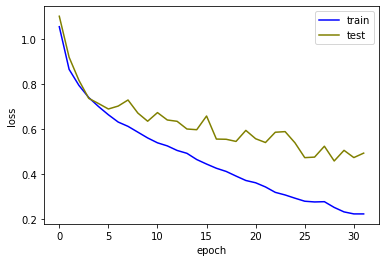


Finished Training

Average Testing Loss: 0.4748437866466502

Average Testing Loss: 0.6252951260263983

Testing on test set
average validation loss: 0.882

Generating Unlabeled Result

Predicting on UH building image
AP = 0.7304975842877504
AP = 0.8300132456721424
AP = 0.39178861744362575
AP = 0.9029397115546622
AP = 0.7310585798575578


In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
%%capture

!zip -r ../segmentation_output.zip /content/segmentation/ # output_test /content/segmentation/output_train